<a href="https://colab.research.google.com/github/sriharikrishna/siamcse21/blob/main/stream_vel_nonlinearopt_w_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: stream_vel application

#### **Purpose**: 
To show the use of automatic differentiation for numerical optimization. The code uses [JAX](https://github.com/google/jax) for AD and [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for the optimization.

#### **Physical Interpretation**:
This code represents a simplified version of the physics of a tidewater glacier -- a fast outlet glacier of the type that flows into the ocean from the Greenland ice sheet. The numerical code simulates the velocity state of the glacier in response to the glacier geometry and physical parameters, such as frictional properties of the bed over which it slides (see e.g. Nick et al, 2010), but in a very simplified, idealized manner.

The optimization example below estimates the magnitude and pattern of the frictional sliding parameter on the basis of an assumed velocity profile. This is a very common type of optimization carried out with a glacier flow model, as it is often the case that we have knowledge of surface properties of an ice sheet, but not of its bed (see e.g. MacAyeal, 1992).


[Nick, F. M., Van Der Veen, C. J., Vieli, A. & Benn, D. I. A physically based
calving model applied to marine outlet glaciers and implications for the
glacier dynamics. J Glaciol 56, 781-794 (2010)](10.3189/002214310794457344)

[MacAyeal, D. R. (1992), The basal stress distribution of Ice Stream E, Antarctica, inferred by control methods, J. Geophys. Res., 97( B1), 595– 603.](https://doi.org/10.1029/91JB02454)

# Primal Code

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.linalg as la
from jax.config import config
config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from jax import random
from jax import float0
import time
import numpy as np

### Define the glacier parameters

In [2]:
# These are the physics constants 
# They can be changed by the user to affect glacier physics
Lx = 79.e3            # domain length
beta_const = 5.       # \beta for sliding law
h_left = 1000.
h_right = 1000.
R_bed = -900.
rhow = 1035.
ep_glen = 1.e-7       # reg. parameter for glen's law
Aglen = 5.0002e-17    # glen's law constant
nglen = 3.            # glen's law exponent
n_nl = 50             # number of times the solve linear system is solved
g = 9.81              # gravity 
rhoi = 910.

The following code computes the stream velocity profile for a given frictional sliding parameter

In [3]:
def stream_vel_init (n, rhoi, g):
    h = jnp.zeros(n)
    beta = jnp.full(n,beta_const)
    dx = Lx / (n*1.0)
    hint = jnp.linspace(start=1,stop=n,num=n,dtype=int)
    hintm1 = jnp.roll(hint,1)
    hintp1 = jnp.roll(hint,-1)
    h = h_left + (h_right-h_left)/Lx * (hint-0.5)*dx
    return h, beta, dx

def stream_vel_taud (h, n, dx, rhoi, g):
    h_minus1 = jnp.roll(h,1)
    h_plus1 = jnp.roll(h,-1)
    f = jnp.append(rhoi * g * h[0] * (h[1]-h[0])/dx, 
                   rhoi * g * h[1:n-1] * 
                   (h_plus1[1:n-1]-h_minus1[1:n-1])/2./dx)
    f = jnp.append(f,rhoi * g * h[n-1] * (h[n-1]-h[n-2])/dx)
    fend = .5 * (rhoi * g * (h[n-1])**2 - rhow * g * R_bed**2) * .5
    return f, fend

def stream_vel_visc (h, u, n, dx):
    ux = jnp.diff(u)/dx
    tmp = jnp.add(jnp.square(ux) , jnp.square(ep_glen))
    nu = .5 * h * Aglen**(-1./nglen) * tmp ** ((1-nglen)/2./nglen)
    return nu

def stream_assemble (nu, beta_fric, n, dx):
    A = jnp.zeros((n,n))
    nu_plus1 = jnp.roll(nu,-1)
    beta_fric_plus1 = jnp.roll(beta_fric,-1)
    A1 = jnp.array(4*nu[0:n-1]/dx + dx/3. 
                   * beta_fric[0:n-1]**2 + 4*nu_plus1[0:n-1]/dx + dx/3. 
                   * beta_fric_plus1[0:n-1]**2)
    A1 = jnp.array(jnp.add(
        jnp.add(4*nu[0:n-1]/dx + dx/3. * jnp.square(beta_fric[0:n-1]) , 
                4*nu_plus1[0:n-1]/dx), 
        dx/3. * jnp.square(beta_fric_plus1[0:n-1])))
    A1 = jnp.append(A1,4*nu[n-1]/dx + dx/3. * beta_fric[n-1]**2)
    A = jnp.diag(A1)
    AL = jnp.diag(jnp.add(-4*nu[1:n]/dx, 
                          dx/6. * jnp.square(beta_fric[1:n])), -1)
    AU = jnp.diag(jnp.add(-4*nu_plus1[0:n-1]/dx , 
                          dx/6. * jnp.square(beta_fric_plus1[0:n-1])),1)
    A = jnp.add(jnp.add(A,AL),AU)
    return A

def stream_vel (bb):
    n = grid_size
    h, beta_fric, dx = stream_vel_init(n, rhoi, g)
    beta_fric = bb + beta_fric
    f, fend = stream_vel_taud (h, n, dx, rhoi, g)
    u = jnp.zeros(n+1)
    #driving stress
    f_plus1 = jnp.roll(f,-1)
    b = jnp.append(-dx * f[0:n-1] - f_plus1[0:n-1] * dx,
                -dx * f[n-1] - f_plus1[n-1] * dx + fend)

    for i in range(n_nl):
        #update viscosities
        nu = stream_vel_visc (h, u, n, dx)
        # assemble tridiag matrix. This represents the discretization of
        #  (nu^(i-1) u^(i)_x)_x - \beta^2 u^(i) = f
        A = stream_assemble (nu, beta_fric, n, dx)

        # solve linear system for new u
        # effectively apply boundary condition u(0)==0
        u = jnp.append(jnp.zeros(1),la.solve(A,b))
    return u

### Visualization functions

In [4]:
def plot_bb(bb, plot_truth=True, plot_optimized=True):
    if plot_truth==True: 
        plt.plot(bb,'b',label='optimized')
    if plot_optimized==True: 
        plt.plot(beta_p_truth,'r',label='truth')
    plt.legend()
    plt.title('parameter beta')
    plt.xlabel('grid point')
    plt.ylabel('$\sqrt{(Pa \, yr/m)}$')
    plt.show()

def plot_velocity(u, plot_truth=True):
    plt.plot(u,'b',label='optimized')
    if plot_truth==True: 
        plt.plot(u_p_truth,'r',label='truth')
    plt.title('velocity')
    plt.xlabel('grid point')
    plt.ylabel('$(m/yr)$')
    plt.legend()
    plt.show()

### Running the Primal Code
Let us run the primal function for a random input

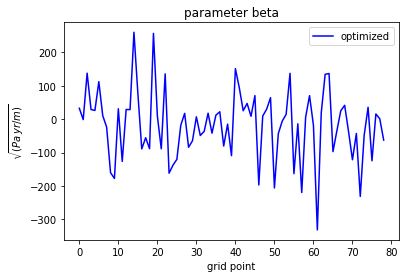

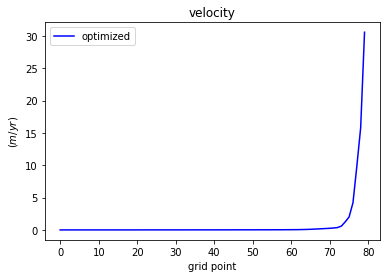

In [5]:
#This value sets the problem size
grid_size = 79

key = random.PRNGKey(0)
bb = random.normal(key, (grid_size,), jnp.float64) * 100

uran = stream_vel(bb)

plot_bb(bb, plot_optimized=False)
plot_velocity(uran, plot_truth=False)

This is what happens when we do not have a sensible parameter value

# Optimization Experiment
Here we can set up the optimization experiment. We create a glacier geometry that we assume is the truth. We then can compute the observations that we would have seen in the physical world.
The geometry is in reality non-observable.

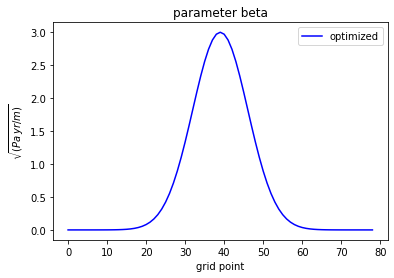

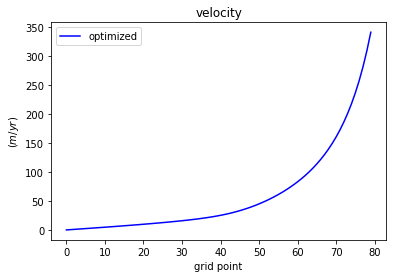

In [6]:
def setup(nloc=79):
  """Sets the observations for an optimization run
     Call this function anytime grid_size or physics constants are changed
  Args:
    nloc: number of grid points
  Returns:
    beta_p_truth : assumed true frictional sliding parameter
    u_p_truth    : true observed velocity
  """
  _,_,dx = stream_vel_init (nloc, rhoi, g)
  xpos = jnp.linspace(dx/2,Lx-dx/2,nloc)

  #This is the assumed true frictional sliding parameter
  beta_p_truth = 3 * jnp.exp(-(xpos-Lx/2)**2/(10.e3)**2)

  #This is the true observed velocity (computed using the assumed true parameter).
  u_p_truth = stream_vel(bb=beta_p_truth)
  return beta_p_truth, u_p_truth

grid_size = 79
beta_p_truth, u_p_truth = setup(grid_size)

plot_bb(beta_p_truth, plot_optimized=False)
plot_velocity(u_p_truth,plot_truth=False)

### Cost function
We can then define a cost function

In [7]:
def cost_func (bb, uref):
    """ Computes the sum of elementwise squared difference
     Args:
       bb: vector, friction parameter
       uref: vector, true velocity
     Returns:
       fc : cost
    """
    print("IN COST FUNC")
    n = bb.size
    u = stream_vel (bb)
    fc = 0.0
    for i in range(1,n+1):
        fc = fc + (u[i]-uref[i])**2
    # regularization
    gamma = 100000
    dx = Lx / (n*1.0)
    fc = fc + gamma * jnp.sum((jnp.diff(bb)/dx)**2)
    return fc

## Gradient Function
We can then define a function to compute the derivatives using JAX. Because there are more inputs (79) than outputs (1), reverse mode AD is appropriate. So, we use <code>jax.grad()</code> 
See the exercises for other options.

In [8]:
#cfg = jax.grad(cost_func, argnums=(0,))
def cost_func_grad (bb, u):   
    print("IN GRAD") 
    #direcmat = cfg(bb, u)
    direcmat = jax.grad(cost_func, argnums=(0,))(bb, u)
    return direcmat[0]

Call the [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) routine (BFGS). Derivatives are provided by <code>get_gradient_cost_func</code> and <code>plot_bb</code> will plot the parameter values for each iteration in BFGS.

In [9]:
#Setup the optimization
grid_size = 79
beta_p_truth, u_p_truth = setup(grid_size)

# The optimization can start either at a intial point that is all zeros or at a random point
#bb = jnp.zeros(n)
key = random.PRNGKey(0)
bb = random.normal(key, (grid_size,), jnp.float64)

# Modify maxiter to make the optimization stop sooner/later
# jac option can be cost_func_vjp, cost_func_jvp, cost_func_jacrev, cost_func_jacfwd, cost_func_grad
res = minimize(cost_func,bb,args=(u_p_truth),tol=1e-1, method='BFGS',
               options={"maxiter":100},
               jac = cost_func_grad,
               callback = plot_bb)




NameError: ignored

Plot the final parameter values and velocity

In [ ]:
bb_final = res["x"]
plot_bb(bb_final)
u = stream_vel(bb=bb_final)
plot_velocity(u)


# Exercises related to Automatic Differentiation and Optimization
1. Change `grid_size`
2. Try a derivative free optimization routine (e.g. Nelder-Mead) (code given below)
3. Change the value of `gamma` in `cost_func()`
4. Compare the performance of different derivative computation routines:
  1. Finite differences (code given below)
  2. `jax.jacfwd()`
  3. `jax.jacrev()`
  4. `jax.jvp()`
  5. `jax.vjp()`
  
The functions are given below


In [ ]:
def cost_func_vjp (bb, u):  
    _, jax_vjp = jax.vjp(cost_func, bb, u)
    directmat = jax_vjp(1.0)
    return directmat[0]

In [ ]:
def cost_func_jvp (bb, u):  
    n = bb.size
    directmat = jnp.empty([0])
    for i in range(n):
        seed = jnp.zeros(n)
        seed = jax.ops.index_update(seed, jax.ops.index[i], 1)
        primal, res = jax.jvp(cost_func, (bb, u), (seed,jnp.zeros(n+1)))
        directmat = jnp.append(directmat, res)
    return directmat

In [ ]:
def cost_func_jacfwd (bb, u):    
    direcmat = jax.jacfwd(cost_func, argnums=(0,))(bb, u)
    return direcmat[0]

In [ ]:
def cost_func_jacrev (bb, u):    
    direcmat = jax.jacrev(cost_func, argnums=(0,))(bb, u)
    return direcmat[0]

## Finite Differences

In [ ]:

# Uncomment to use finite differences to compute the derivatives.
# Use grid_size=10 for timely convergence
# Modify maxiter to make the optimization stop sooner/later
'''
grid_size = 10
beta_p_truth, u_p_truth = setup(grid_size)
key = random.PRNGKey(0)
bb = random.normal(key, (grid_size,), jnp.float64)
res = minimize(cost_func,bb,args=(u_p_truth),tol=1e-1, method='BFGS',
               options={"maxiter":40}, # Reduce this value to make the optimization stop sooner
               jac = '2-point',
               callback = plot_bb)
'''

## Derivative Free Optmization (Nelder-Mead)

In [ ]:

# Uncomment to use derivative free optimization (Nelder-Mead)
# Use grid_size=5 for timely convergence
# Modify maxiter to make the optimization stop sooner/later
'''
grid_size = 5
beta_p_truth, u_p_truth = setup(grid_size)
key = random.PRNGKey(0)
bb = random.normal(key, (grid_size,), jnp.float64)
res = minimize(cost_func,bb,args=(u_p_truth), method='Nelder-Mead',
               options={"maxiter":100,'disp': True,}, 
               callback = plot_bb)
'''

# Exercises related to Glaciology
1. Change glacier physics by modifying the constants
2. Change `setup()` to create a different `beta_p_truth` and `u_p_truth`